<a href="https://colab.research.google.com/github/ridwanbello/facial-expression-vggface-pytorch/blob/master/PyTorch_with_VGGFace_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.nn.init import *
from torchvision import transforms, utils, datasets, models
import cv2
from PIL import Image
from pdb import set_trace
import time
import copy
from pathlib import Path
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage import io, transform
from tqdm import trange, tqdm
import csv
import glob
import dlib
import pandas as pd
import numpy as np

In [ ]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip "/content/gdrive/MyDrive/fers-data.zip"

Streaming output truncated to the last 5000 lines.
 extracting: fers-data/train/angry/284.jpg  
 extracting: fers-data/train/angry/285.jpg  
 extracting: fers-data/train/angry/286.jpg  
 extracting: fers-data/train/angry/287.jpg  
 extracting: fers-data/train/angry/288.jpg  
 extracting: fers-data/train/angry/289.jpg  
 extracting: fers-data/train/angry/29.jpg  
 extracting: fers-data/train/angry/290.jpg  
 extracting: fers-data/train/angry/291.jpg  
 extracting: fers-data/train/angry/292.jpg  
 extracting: fers-data/train/angry/293.jpg  
 extracting: fers-data/train/angry/295.jpg  
 extracting: fers-data/train/angry/296.jpg  
 extracting: fers-data/train/angry/297.jpg  
 extracting: fers-data/train/angry/298.jpg  
 extracting: fers-data/train/angry/3.jpg  
 extracting: fers-data/train/angry/300.jpg  
 extracting: fers-data/train/angry/301.jpg  
 extracting: fers-data/train/angry/302.jpg  
 extracting: fers-data/train/angry/304.jpg  
 extracting: fers-data/train/angry/306.jpg  
 extrac

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Resize((224,224)),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.4),
        transforms.RandomRotation(5, expand=False, center=None),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224,224)),
       transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.4),
        transforms.RandomRotation(5, expand=False, center=None),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}
data_dir = "/content/fers-data"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x],
                                              batch_size=8, 
                                             shuffle=True)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes
class_names

['angry', 'fear', 'happy', 'sad', 'surprise']

In [ ]:
!pip install facenet-pytorch

     |████████████████████████████████| 1.9 MB 5.3 MB/s 


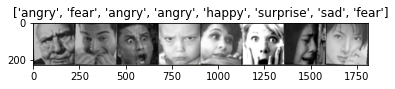

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [ ]:
from facenet_pytorch import MTCNN, InceptionResnetV1

model_ft = InceptionResnetV1(pretrained='vggface2', classify=False, num_classes = len(class_names))

list(model_ft.children())[-6:]

layer_list = list(model_ft.children())[-5:] # all final layers

model_ft = nn.Sequential(*list(model_ft.children())[:-5])

for param in model_ft.parameters():
    param.requires_grad = False
    
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x
      
class normalize(nn.Module):
    def __init__(self):
        super(normalize, self).__init__()
        
    def forward(self, x):
        x = F.normalize(x, p=2, dim=1)
        return x    
model_ft.avgpool_1a = nn.AdaptiveAvgPool2d(output_size=1)

model_ft.last_linear = nn.Sequential(
    Flatten(),
    nn.Linear(in_features=1792, out_features=512),
    nn.ReLU(),
    nn.Linear(in_features=512, out_features=256),
    normalize()
)

model_ft.logits = nn.Linear(model_ft.last_linear[3].out_features, len(class_names))
model_ft.softmax = nn.Softmax(dim=1)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-2)

# Decay LR by a factor of *gamma* every *step_size* epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)  

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=1e-2, momentum=0.9)
# Decay LR by a factor of *gamma* every *step_size* epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft

Sequential(
  (0): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (1): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (2): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (5): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3,

In [ ]:
def train_model(model, criterion, optimizer, scheduler,
                num_epochs=25):
    since = time.time()
    FT_losses = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
    # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()
                
                FT_losses.append(loss.item())
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, FT_losses

Epoch 0/49
----------
train Loss: 1.5883 Acc: 0.3016
val Loss: 1.5867 Acc: 0.2954
Epoch 1/49
----------
train Loss: 1.5889 Acc: 0.2953
val Loss: 1.5868 Acc: 0.3083
Epoch 2/49
----------
train Loss: 1.5888 Acc: 0.2946
val Loss: 1.5881 Acc: 0.2963
Epoch 3/49
----------
train Loss: 1.5886 Acc: 0.2951
val Loss: 1.5879 Acc: 0.2991
Epoch 4/49
----------
train Loss: 1.5894 Acc: 0.2944
val Loss: 1.5867 Acc: 0.3065
Epoch 5/49
----------
train Loss: 1.5885 Acc: 0.2986
val Loss: 1.5875 Acc: 0.3056
Epoch 6/49
----------
train Loss: 1.5891 Acc: 0.2946
val Loss: 1.5878 Acc: 0.3000
Epoch 7/49
----------
train Loss: 1.5886 Acc: 0.2949
val Loss: 1.5872 Acc: 0.3037
Epoch 8/49
----------
train Loss: 1.5879 Acc: 0.2976
val Loss: 1.5860 Acc: 0.3157
Epoch 9/49
----------
train Loss: 1.5888 Acc: 0.2937
val Loss: 1.5881 Acc: 0.2981
Epoch 10/49
----------
train Loss: 1.5898 Acc: 0.2895
val Loss: 1.5903 Acc: 0.2843
Epoch 11/49
----------
train Loss: 1.5888 Acc: 0.2932
val Loss: 1.5875 Acc: 0.3074
Epoch 12/49
--

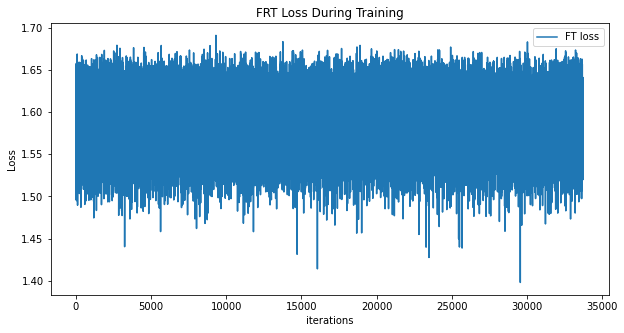

In [ ]:
model_ft, FT_losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=50)
plt.figure(figsize=(10,5))
plt.title("FRT Loss During Training")
plt.plot(FT_losses, label="FT loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

torch.save(model_ft, "/model.pt")

In [ ]:
!unzip "/content/gdrive/MyDrive/fer.zip"

In [ ]:
test_data_path = "/content/fer"
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
test_data = datasets.ImageFolder(root=test_data_path, transform=transform)
test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size=8, shuffle=True, num_workers=0) 
classes = ('angry', 'fear', 'happy', 'sad', 'surprise')

In [ ]:
resnet = InceptionResnetV1(pretrained='vggface2').eval()

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        labels = labels.to(device=device)
        images = images.to(device=device)
        # calculate outputs by running images through the network
        outputs = model_ft(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))